### Build a heatmap over the allocation of the reciprocal best Hit BLAST results grouped by their organisms' genus

The reciprocal Best Hit BLAST results have to be converted from the html to a csv in a first step. 

The heatmap is created according to all accesion ids in the acc_id file. 

The names for the corresponding cluster have to be given as input argument (type: list of strings), in the same order as the accesion ids. If this list is not given, the accesion ids will be given as names on the heatmap.

##### TODOs 

- remove NaN row (?)
- get only those genera, that have hits for specific proteins

        - get a better heatmap (colors even with a few high values?) -- solved with logarithmic scale 
- how to create namelist - combining with WP? 
- add further geni, that are not given by the current clusters?


##### For complete heatmap: 
        - add 'class' label, eg cyanobacteria, other prokaryotes and eukaryotes -- solved with ete3
- sort after class labels 
- plot phylum and superkingdom label column 
- define when extra sorting should be used 

In [1]:
import pandas as pd
import numpy as np

##for plotting:
import matplotlib as mlp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

%matplotlib inline

In [29]:
'''
Function takes an input dataframe given through the reciprocal BLAST.
The genus for the corresponding protein(given through its WP) is filterd out and stored in a list.
The function returns a list of the genus of all organisms that realign best to the given protein number. 
input arguments: BLAST_output dataframe, preprocessed with the taxonomy script (type:dataframe, csv read in with pandas), WP_number to best realign to (type_string)
'''
def extract_genuslist(df, WP_num):
    genuslist= []
    for i in range(len(df)):
        if df.qseqid [i] == WP_num:
            if pd.isnull(df.genus[i]) == False: ## to sort out NaN values
                genuslist.append(df.genus[i])
       
    print('Entries in genuslist for', WP_num, ':', len(genuslist))
    return(genuslist)

In [41]:
def get_taxonomy_table(df):
    taxdf= df[['genus','phylum','superkingdom' ]]
    taxdf = taxdf.drop_duplicates()
    #taxdf.set_index('genus',inplace = True)
    return(taxdf)

In [39]:
'''
The function takes the genuslist and counts the occurence of each genus in the list.
Its outputs the number of occurences per genus in a dataframe.
Input arguments: list with all the geni of the organisms owning the protein(type: list) and the proteinname (type: string)
'''

def count_copies (genlist, protname):
    gendict = {x:genlist.count(x) for x in genlist}
    d =pd.DataFrame.from_dict(gendict,orient='index')
    d.columns = [protname]
    d.index.name = 'genus'
    d.reset_index(inplace=True)
    print('number of genera:', len(d))
    return(d)

In [40]:
count_copies(extract_genuslist(workingcsv,'WP_011242471'),'WP_011242471')

Entries in genuslist for WP_011242471 : 32
number of genera: 14


,genus,WP_011242471
0,Synechococcus,11
1,Gloeomargarita,1
2,Thermosynechococcus,6
3,Cyanobium,1
4,Scytonema,1
5,Acaryochloris,1
6,Nostoc,4
7,Halomicronema,1
8,Candidatus Atelocyanobacterium,1
9,Pseudanabaena,1


In [33]:
def get_dataframe (acc_ids, workingcsv, namelist = None):
    num_acc_ids = len(acc_ids)
    
    df_prot = get_taxonomy_table(workingcsv)
    
    
    for i in range(num_acc_ids):
        
        df = count_copies(extract_genuslist(workingcsv,acc_ids.iloc[i,0]),( namelist[i] if namelist else acc_ids.iloc[i,0]))
    
        df_prot = pd.merge(df_prot, df, how='outer')
        
        
    df_prot = df_prot.drop_duplicates()
    df_prot = df_prot.fillna(0)   
    
    return(df_prot)

In [62]:
'''
Short function combining the functions above. 
Function takes the BLAST_data (Accession ID list (txt document) and BLAST result csv to read them in and creates a dataframe 
of the amount of occurence for all given protein clusters per genome. Only genomes that occur at least one at one protein cluster
are taken into consioderation)
'''
def preparing_heatmap(Acc_id_name, Resultcsv, namelist = None):
    
    acc_ids = pd.read_csv(Acc_id_name, header=None)
    workingcsv = pd.read_csv(Resultcsv)
    
    frame= get_dataframe(acc_ids, workingcsv, namelist = namelist)
    taxlist= ['phylum','superkingdom']
    protlist = namelist if namelist else acc_ids[0].tolist()
    collist = taxlist + protlist
    
    dat = frame[collist]
    dat.index= list(frame['genus'])
    
    print('Dataframe with shape', dat.shape, 'has been successfully created')
    return(dat)

In [8]:
protnames=['BcsA1','XcsB2','BcsA2','XcsA','XcsB','XcsC','AcrA','AcrB','SFT','ABC1','ABC2','GTF1','GTF2','HlyD','peptidase','LptFG','LptB','LptA','LPS','LptC','LptD','FtsX','HlyD2','ABC3','HlyD3','PteB','RND1','RND2','TolC','MlaE','permease','S-layer','ABC4','ABC5','ABC6','TPR','RND3','export']

In [68]:
acc_ids = pd.read_csv('acc_ids.txt', header=None)

In [63]:
frame = preparing_heatmap('acc_ids.txt','Cyanodata.csv')

Entries in genuslist for WP_011378340 : 103
number of genera: 24
Entries in genuslist for WP_011378341 : 18
number of genera: 6
Entries in genuslist for WP_011243364 : 148
number of genera: 43
Entries in genuslist for WP_011242471 : 32
number of genera: 14
Entries in genuslist for WP_039755718 : 41
number of genera: 17
Entries in genuslist for WP_011378019 : 80
number of genera: 28
Entries in genuslist for WP_011244046 : 334
number of genera: 51
Entries in genuslist for WP_011378431 : 561
number of genera: 53
Entries in genuslist for WP_011244513 : 177
number of genera: 45
Entries in genuslist for WP_011378231 : 243
number of genera: 50
Entries in genuslist for WP_011378232 : 123
number of genera: 44
Entries in genuslist for WP_011378235 : 116
number of genera: 37
Entries in genuslist for WP_011244503 : 111
number of genera: 36
Entries in genuslist for WP_011244501 : 602
number of genera: 54
Entries in genuslist for WP_011378236 : 810
number of genera: 53
Entries in genuslist for WP_01

In [64]:
frame

,phylum,superkingdom,WP_011378340,WP_011378341,WP_011243364,WP_011242471,WP_039755718,WP_011378019,WP_011244046,WP_011378431,...,WP_011378177,WP_011243448,WP_011243394,WP_011243386,WP_011243384,WP_011243359,WP_011377610,WP_011377614,WP_011377621,WP_011377674
Nostoc,Cyanobacteria,Bacteria,20.0,1.0,10.0,4.0,7.0,15.0,46.0,96.0,...,44.0,38.0,23.0,214.0,32.0,62.0,61.0,65.0,63.0,0.0
Calothrix,Cyanobacteria,Bacteria,16.0,2.0,11.0,1.0,3.0,7.0,23.0,34.0,...,19.0,18.0,9.0,100.0,11.0,26.0,25.0,32.0,24.0,0.0
Synechococcus,Cyanobacteria,Bacteria,18.0,7.0,48.0,11.0,10.0,7.0,108.0,164.0,...,128.0,60.0,63.0,39.0,22.0,69.0,72.0,75.0,67.0,1.0
Leptolyngbya,Cyanobacteria,Bacteria,8.0,0.0,5.0,0.0,1.0,4.0,6.0,17.0,...,7.0,7.0,6.0,26.0,11.0,13.0,13.0,14.0,14.0,0.0
Anabaena,Cyanobacteria,Bacteria,1.0,0.0,2.0,0.0,0.0,0.0,4.0,6.0,...,6.0,5.0,2.0,20.0,3.0,6.0,8.0,6.0,6.0,0.0
Thermosynechococcus,Cyanobacteria,Bacteria,11.0,6.0,9.0,6.0,6.0,6.0,5.0,6.0,...,11.0,6.0,6.0,6.0,6.0,12.0,11.0,16.0,6.0,0.0
Oxynema,Cyanobacteria,Bacteria,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,...,2.0,1.0,1.0,10.0,0.0,2.0,2.0,3.0,1.0,0.0
Scytonema,Cyanobacteria,Bacteria,2.0,0.0,3.0,1.0,2.0,4.0,10.0,17.0,...,2.0,2.0,2.0,17.0,2.0,6.0,7.0,10.0,9.0,0.0
Tolypothrix,Cyanobacteria,Bacteria,1.0,0.0,2.0,0.0,0.0,2.0,6.0,12.0,...,4.0,4.0,2.0,20.0,3.0,6.0,6.0,9.0,4.0,0.0
Koinonema,Cyanobacteria,Bacteria,1.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,...,2.0,0.0,1.0,8.0,1.0,2.0,2.0,2.0,1.0,0.0


In [70]:
'''
short function that crates a sub-dataframe from the overall-results-datadrame. 
Input: the results dataframe created with the function preparing_heatmap
        a list of strings containing the Protein Ids or names(if argument namelist given in preparing heatmap) 
            of the proteins needed in the sub-dataframe
'''
def create_subframes(df,columnnames):
    
    newframe= df[columnnames]
    
    return newframe

In [71]:
frame_simple_heatmap = create_subframes(frame, acc_ids[0].tolist() )

In [61]:
SubA = create_subframes(frame, ['WP_011378340','WP_011243364','WP_011242471'])
SubA

,WP_011378340,WP_011243364,WP_011242471
Nostoc,20.0,10.0,4.0
Calothrix,16.0,11.0,1.0
Synechococcus,18.0,48.0,11.0
Leptolyngbya,8.0,5.0,0.0
Anabaena,1.0,2.0,0.0
Thermosynechococcus,11.0,9.0,6.0
Oxynema,1.0,1.0,0.0
Scytonema,2.0,3.0,1.0
Tolypothrix,1.0,2.0,0.0
[Phormidium],1.0,1.0,0.0


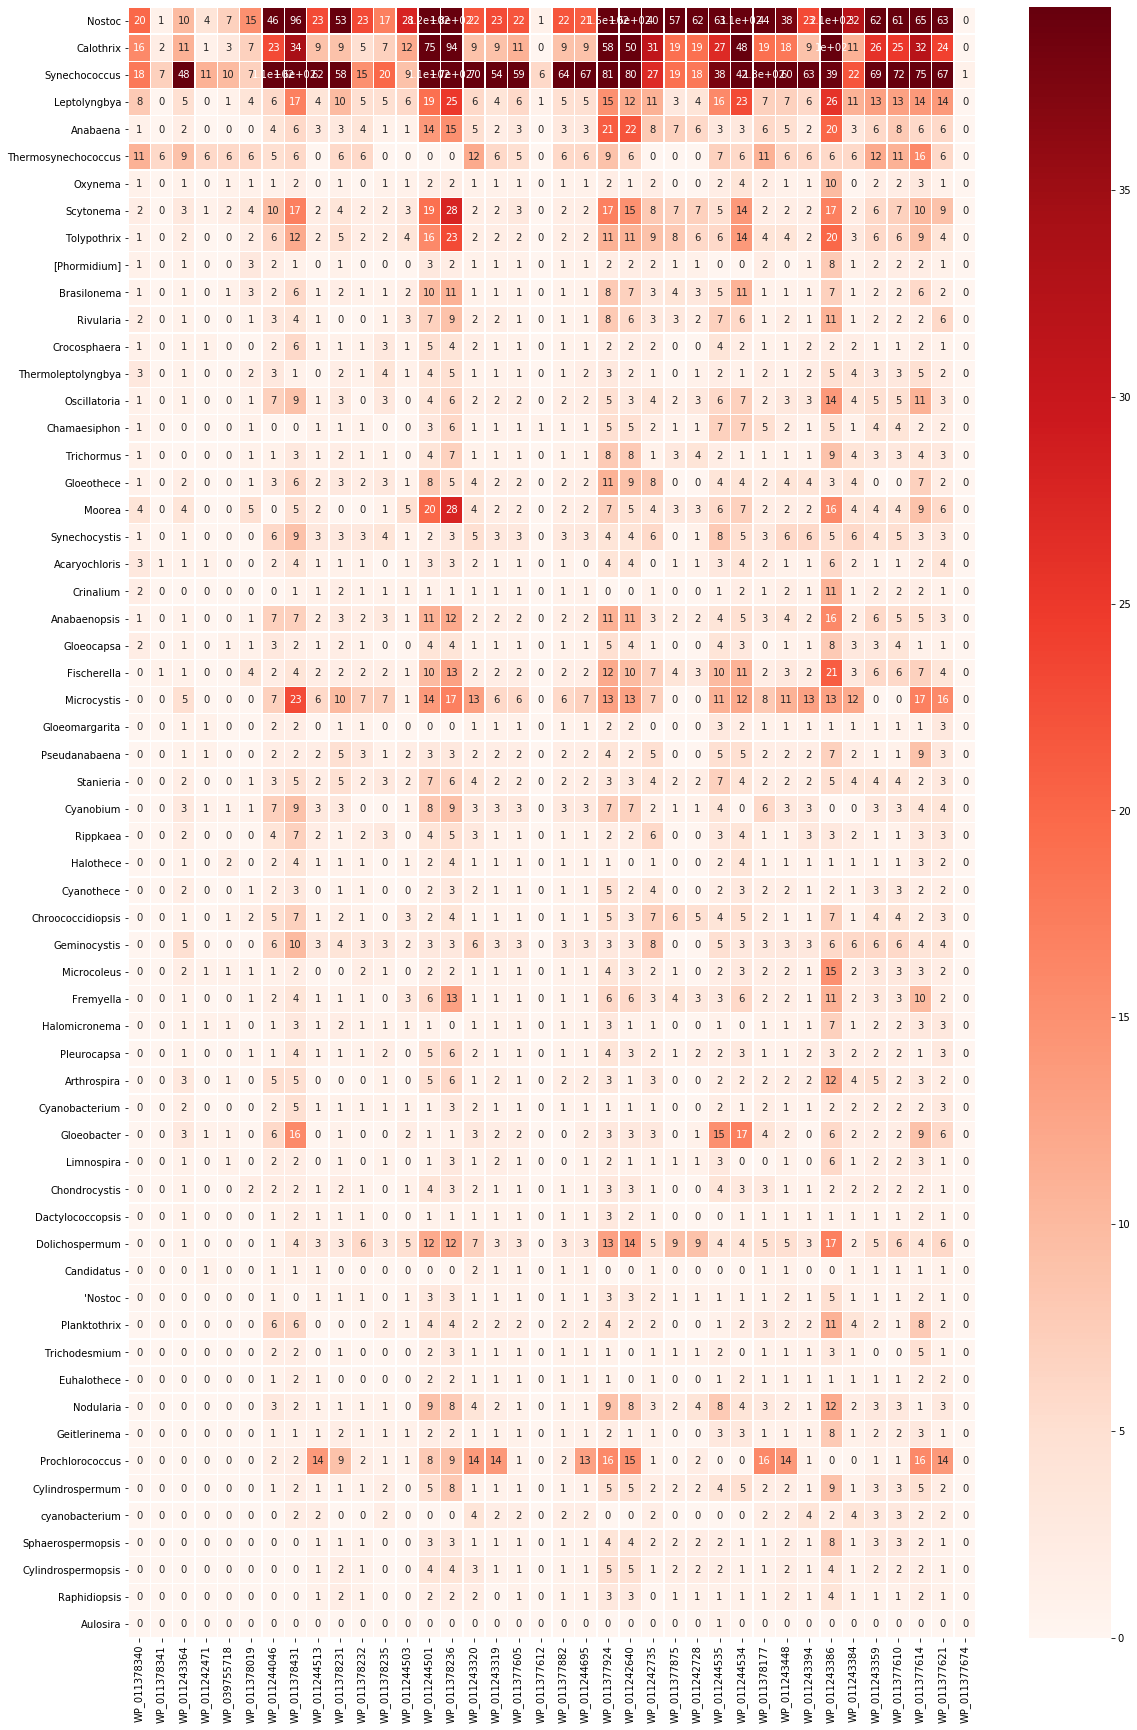

In [19]:
f = plt.figure(figsize=(19,30.0))
sns.heatmap(frame, cmap='Reds', linewidths=0.5, annot=True, robust = True)

#plt.savefig('Heatmap_new.pdf')

In [29]:
frame.shape

(1835, 38)

In [65]:
'''
function to create a heatmap, given the dataframe created with the function preparing_heatmap or create_subframes.

Addicitonal Input arguments: saving: string of the name the saved figure should have.(eg 'heatmap.pdf'). 
                                 If a name is given, the figure will be saved
                             log: is true, a logarithmic scale is chosen for the heatmap. 
                                 If False, the linear scale is chosen
'''
def create_heatmap(df, saving = None, log = True):
    
    
    
    frameshape = df.shape
    if frameshape[0] < 100:
        f = plt.figure(figsize=(frameshape[1]/2+6,frameshape[0]/2))

        plots = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.1,
                              width_ratios=[frameshape[1]/2, 4, frameshape[1]/20])
    
    else:
        f=  plt.figure(figsize=(frameshape[1]/2+6,100))

        plots = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.1,
                              width_ratios=[frameshape[1]/2, 4, .5])
    


    syn_heat = f.add_subplot(plots[0,0])
    
    # Remove the tick marks and place labels at top, bottom, and right  
    syn_heat.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom="on", 
                    labelleft=False, labelright="on")

    syn_heat.set_xticks(np.arange(frameshape[1])+0.5, minor=False)
    syn_heat.set_yticks(np.arange(frameshape[0])+0.5, minor=False)
    
    # Add x-axis labels
    
    syn_heat.set_xticklabels(df.columns, fontsize=20, rotation=90)
        
    if frameshape[0] < 100:
        syn_heat.set_yticklabels(df.index, fontsize=20)
    else:
        syn_heat.set_yticklabels(df.index, fontsize=5)
       

    heat_syn = plt.pcolor(df,cmap= "Reds", norm=mlp.colors.LogNorm ()if log else None)


    bar_heat = f.add_subplot(plots[0,2])
    cbar = plt.colorbar(heat_syn, bar_heat )
    cbar.ax.tick_params(length=10, width=5)
    cbar.ax.tick_params(labelsize=20)
    #cbar.ax.set_yticklabels(fontsize=20)
    cbar.set_label('Protein abundance', fontsize=30)
    
    
    
    if saving : 
        plt.savefig(saving)

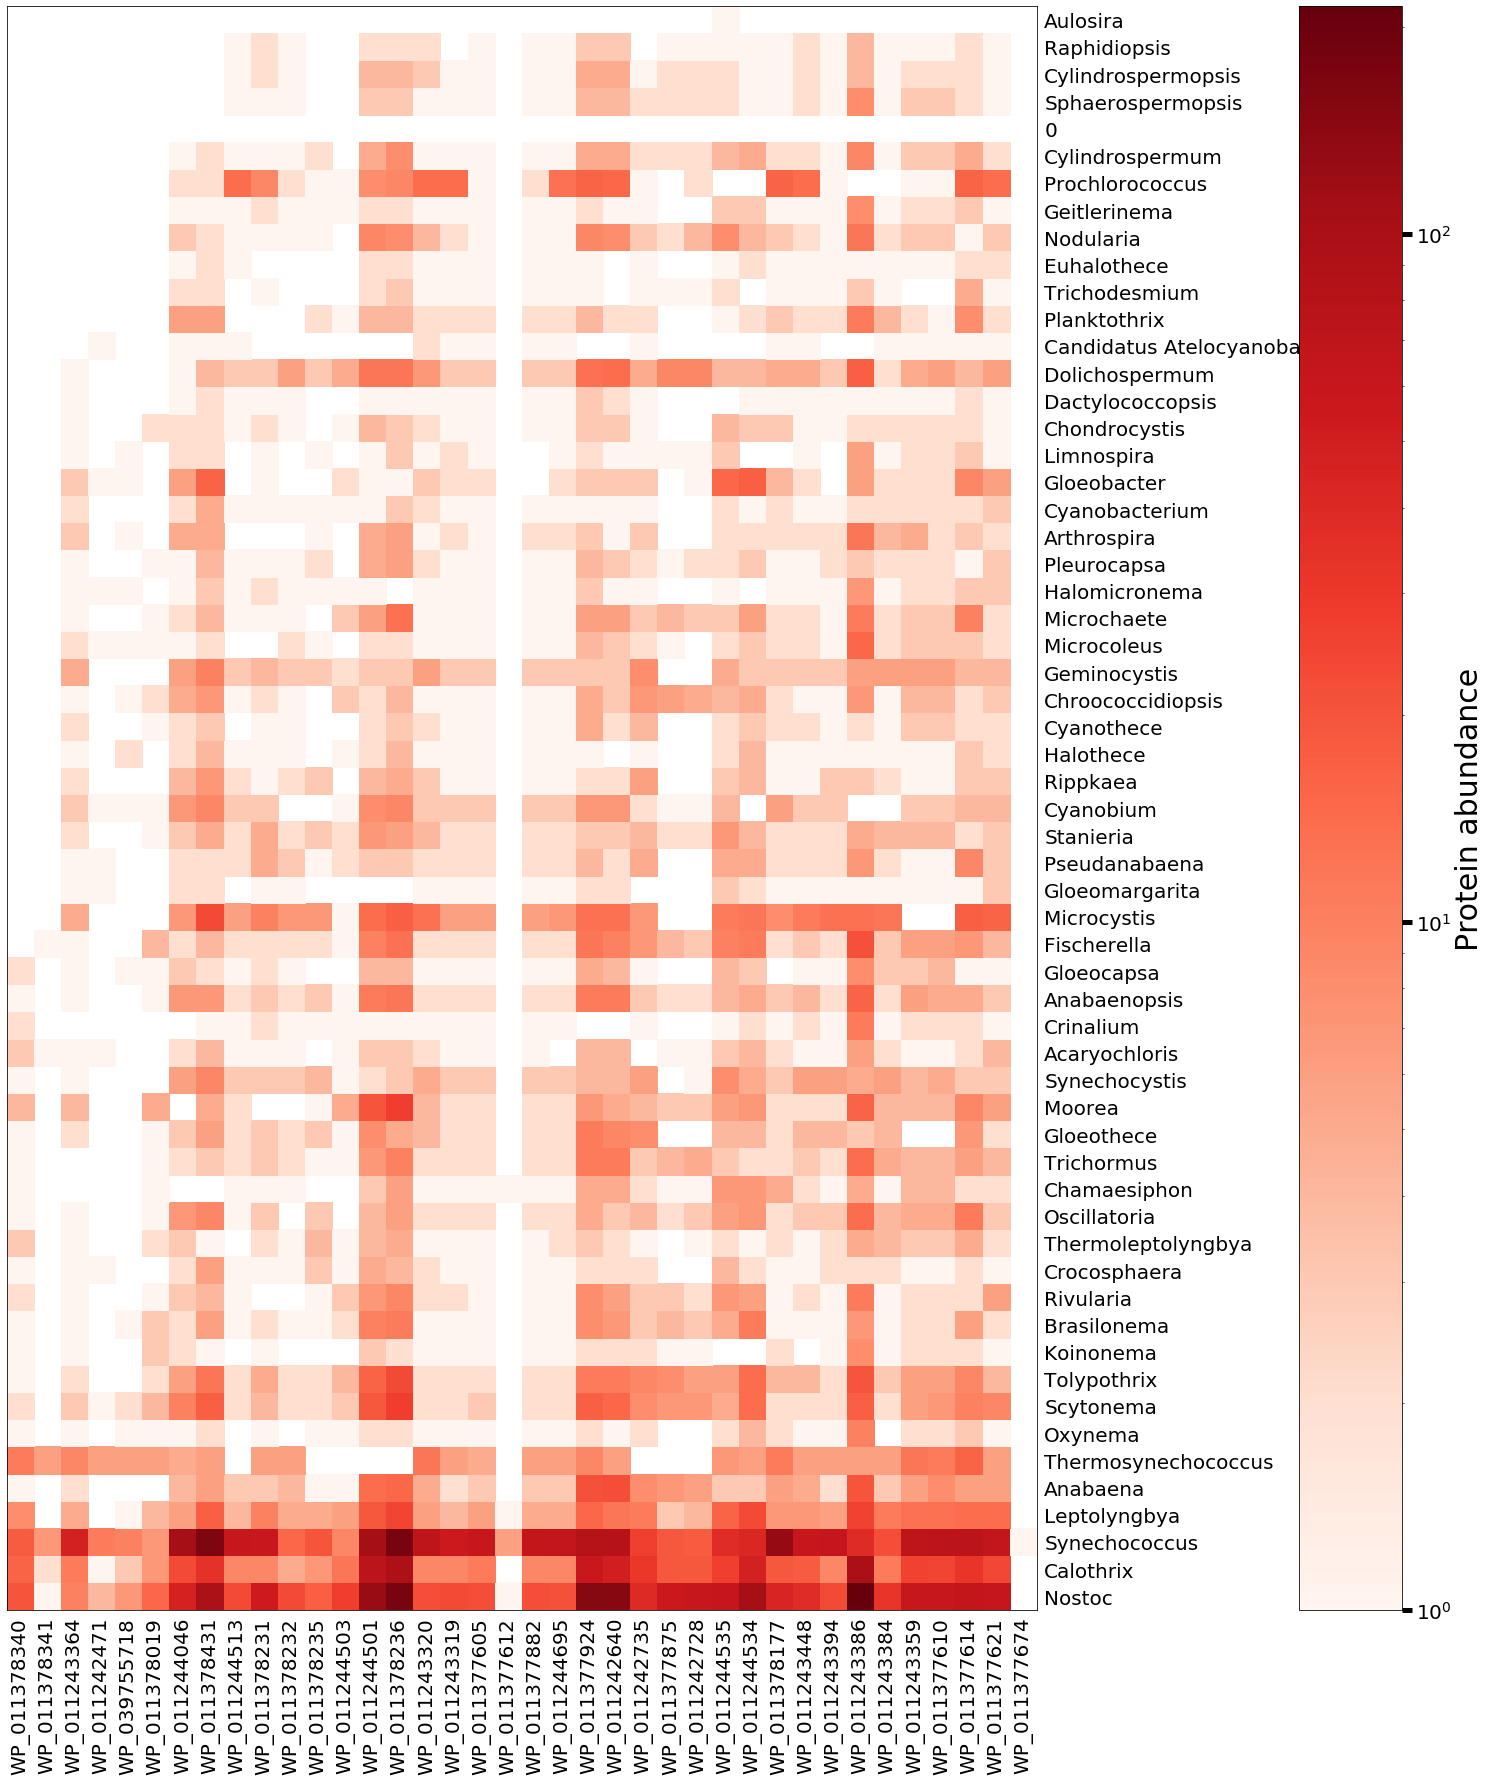

In [72]:
create_heatmap(frame_simple_heatmap)

In [102]:
listofframes=[frame,SubA]

In [100]:
frame.shape

(60, 38)

In [7]:
'''
function to create a heatmap, given a lsi of dataframes created with the function preparing_heatmap or create_subframes.

Addicitonal Input arguments: saving: string of the name the saved figure should have.(eg 'heatmap.pdf'). 
                                 If a name is given, the figure will be saved
                             log: is true, a logarithmic scale is chosen for the heatmap. 
                                 If False, the linear scale is chosen
'''
def create_heatmap_from_list(dflist, saving = None, log = True):
    
    numframes= len(dflist)
    
    height = []
    width =[]
    maxval = []
    for i in range(numframes):
        height.append (listofframes[i].shape[0]/2)
        height.append (0.5)   
        width.append(listofframes[i].shape[1]/2)
        width.append(0.5)
        maxval.append(listofframes[i].max().max())
        
    
    width.append(3)    
    width.append(1) 
    sumheight= sum(height)
    sumwidth = sum(width) 
    
    max_value = max(maxval)
    
    print(height, width)
    
    f = plt.figure(figsize=(sumwidth+1,sumheight))

    plots = gridspec.GridSpec(1, numframes*2+2, wspace=0.05, hspace=0.1, width_ratios=width)

    for i in range(numframes):
        syn_heat = f.add_subplot(plots[0,i*2])
        frame = dflist[i]
        # Remove the tick marks and place labels at top, bottom, and right  
        if i == numframes-1:
            syn_heat.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom="on", 
                    labelleft=False, labelright="on")
                 
            syn_heat.set_xticks(np.arange(frame.shape[1])+0.5, minor=False)
            syn_heat.set_yticks(np.arange(frame.shape[0])+0.5, minor=False)
                 
            syn_heat.set_xticklabels(frame.columns, fontsize=20, rotation=90)
            syn_heat.set_yticklabels(frame.index, fontsize=20)
   
                 
        else: 
            syn_heat.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom="on", 
                    labelleft=False, labelright=False)     

            syn_heat.set_xticks(np.arange(frame.shape[1])+0.5, minor=False)
            #syn_heat.set_yticks(np.arange(frame.shape[0])+0.5, minor=False)
    

            syn_heat.set_xticklabels(frame.columns, fontsize=20, rotation=90)
            #syn_heat.set_yticklabels(df.index, fontsize=20)
   
        heat_syn = plt.pcolor(frame,cmap= "Reds",vmax= max_value ,norm=mlp.colors.LogNorm ()if log else None)


    bar_heat = f.add_subplot(plots[0,-1])
    cbar = plt.colorbar(heat_syn, bar_heat )
    cbar.ax.tick_params(length=10, width=5)
    cbar.ax.tick_params(labelsize=20)
    #cbar.ax.set_yticklabels(fontsize=20)
    cbar.set_label('Protein abundance', fontsize=30)
    
    
    
    if saving : 
        plt.savefig(saving)

[30.0, 0.5, 30.0, 0.5] [19.0, 0.5, 1.5, 0.5, 3, 1]


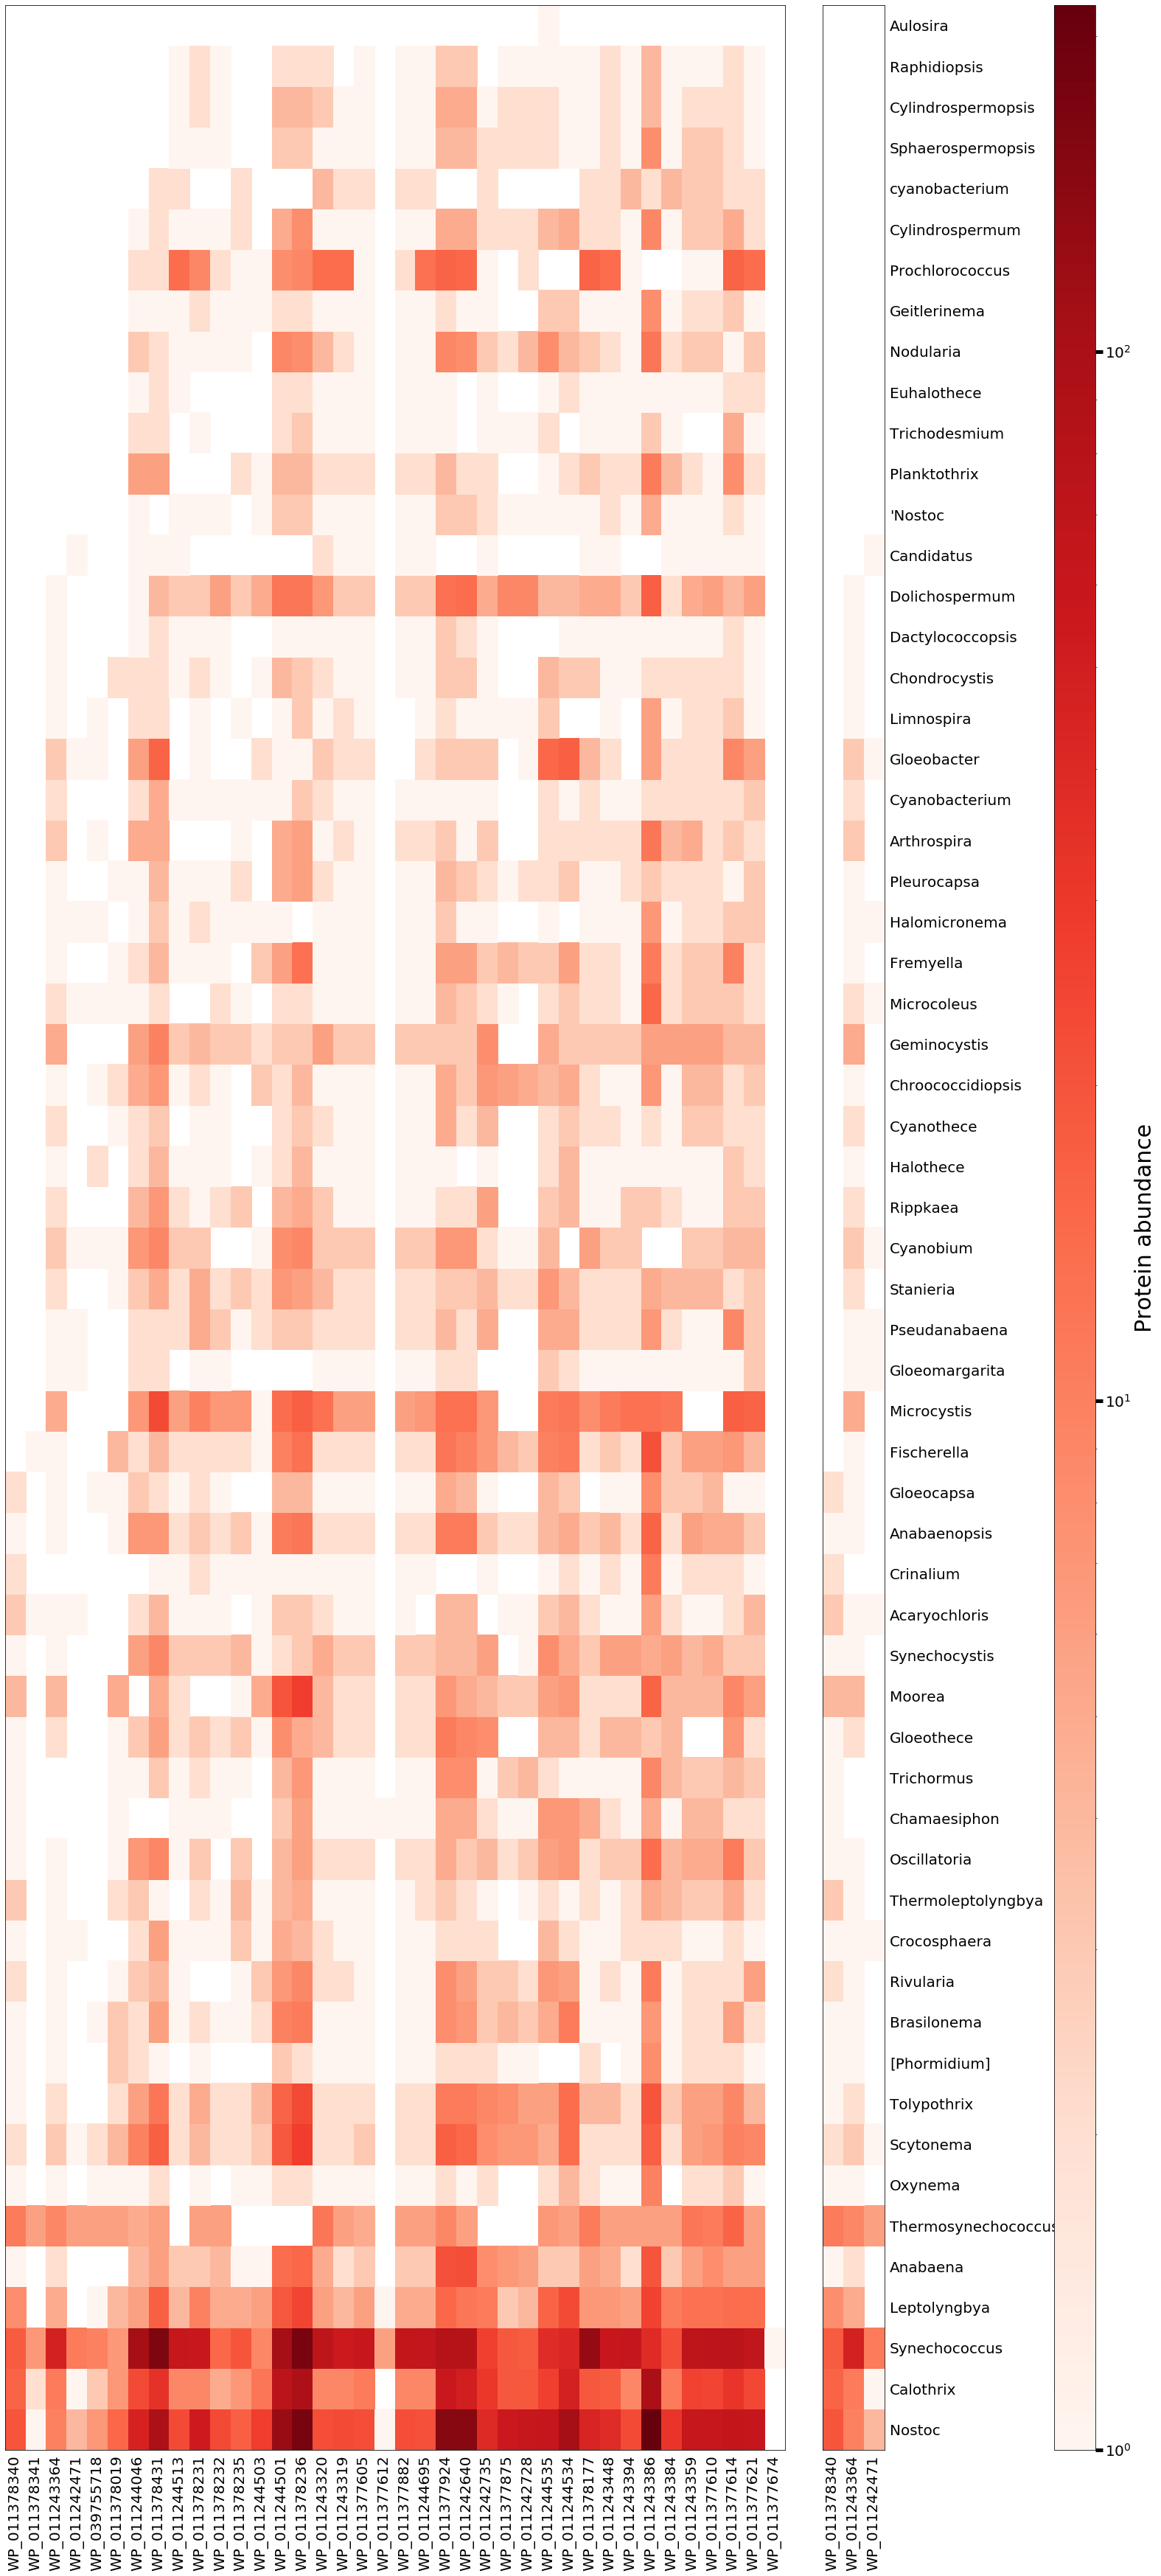

In [124]:
create_heatmap_from_list(listofframes, saving= 'multipleheatmaps.pdf')

In [105]:
sumheight

122

In [121]:
frame.max().max()

214.0

## Complete Data:

In [23]:
frame = preparing_heatmap('acc_ids.txt','BLASTResultTable1.csv')

Entries in genuslist for WP_011378340 : 3327
number of geni: 366
Entries in genuslist for WP_011378341 : 231
number of geni: 41
Entries in genuslist for WP_011243364 : 404
number of geni: 124
Entries in genuslist for WP_011242471 : 285
number of geni: 63
Entries in genuslist for WP_039755718 : 1051
number of geni: 140
Entries in genuslist for WP_011378019 : 3836
number of geni: 438
Entries in genuslist for WP_011244046 : 3135
number of geni: 446
Entries in genuslist for WP_011378431 : 3222
number of geni: 458
Entries in genuslist for WP_011244513 : 3887
number of geni: 609
Entries in genuslist for WP_011378231 : 1856
number of geni: 407
Entries in genuslist for WP_011378232 : 2590
number of geni: 468
Entries in genuslist for WP_011378235 : 1273
number of geni: 463
Entries in genuslist for WP_011244503 : 1008
number of geni: 321
Entries in genuslist for WP_011244501 : 4169
number of geni: 446
Entries in genuslist for WP_011378236 : 3524
number of geni: 470
Entries in genuslist for WP_01

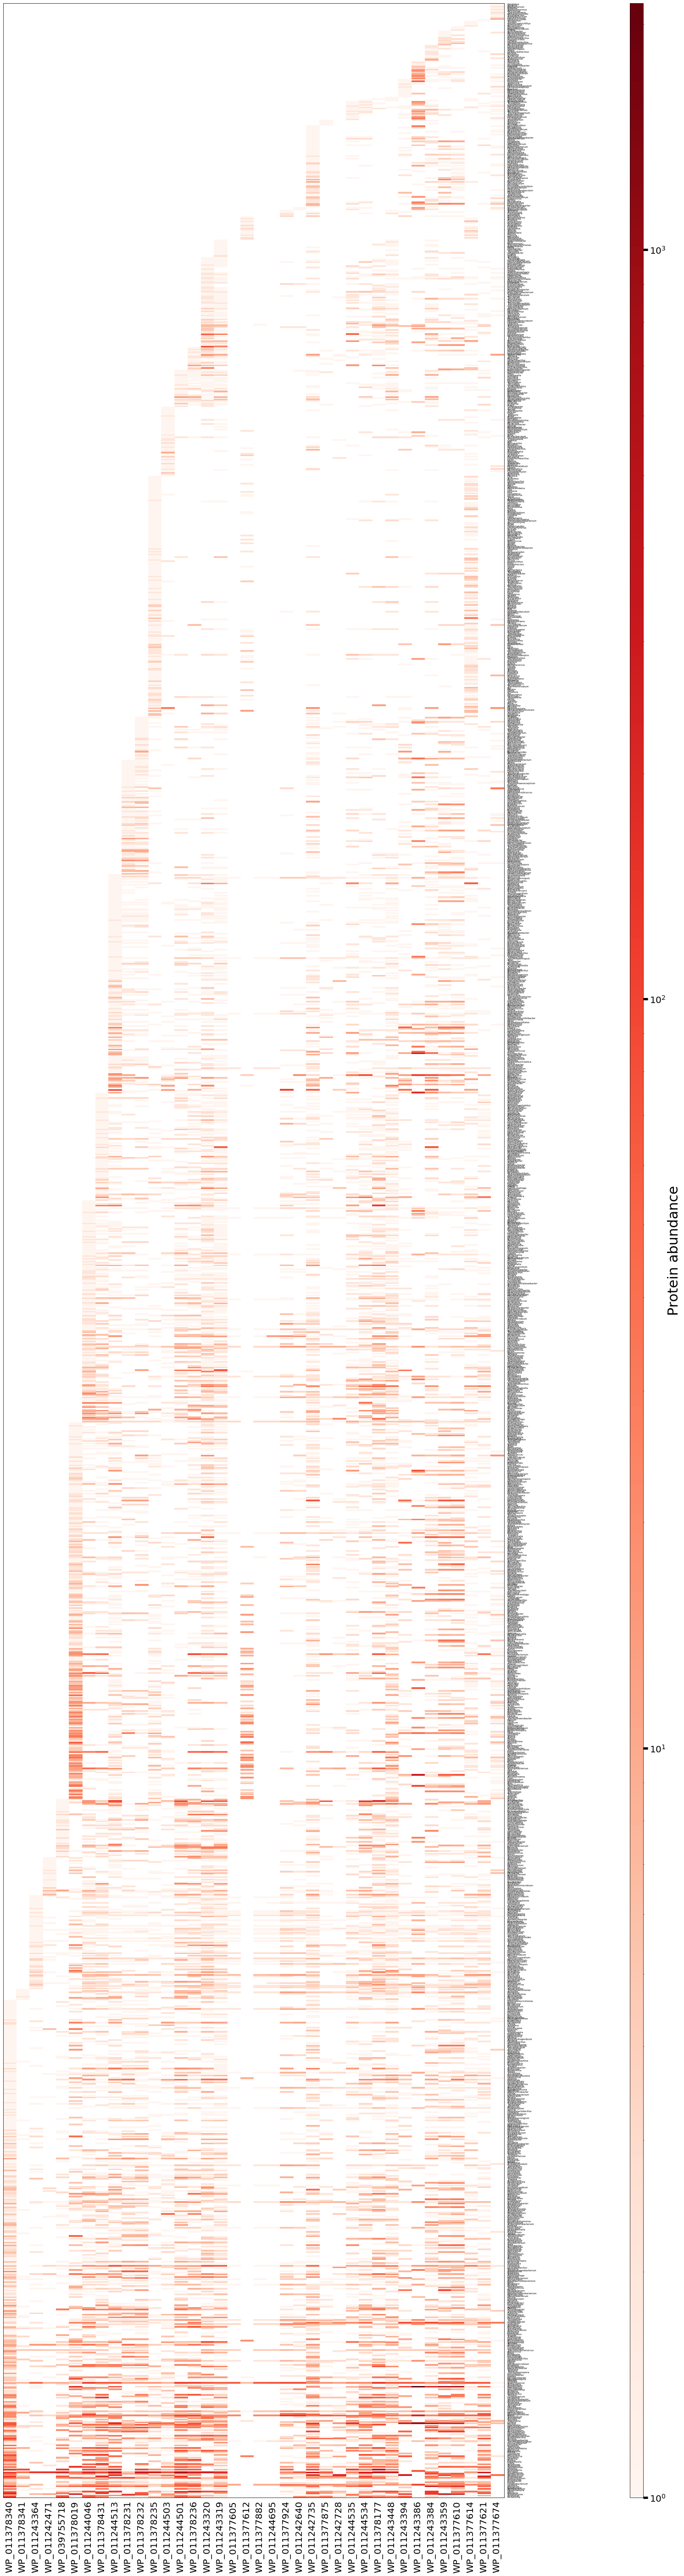

In [38]:
create_heatmap(frame)

In [22]:
workingcsv = pd.read_csv('Cyanodata.csv')
get_taxonomy_table(workingcsv)

,phylum,superkingdom
genus,,
Nostoc,Cyanobacteria,Bacteria
Calothrix,Cyanobacteria,Bacteria
Synechococcus,Cyanobacteria,Bacteria
Leptolyngbya,Cyanobacteria,Bacteria
Anabaena,Cyanobacteria,Bacteria
Thermosynechococcus,Cyanobacteria,Bacteria
Oxynema,Cyanobacteria,Bacteria
Scytonema,Cyanobacteria,Bacteria
Tolypothrix,Cyanobacteria,Bacteria
